In [153]:
# 標準答案

import talib
import numpy as np
import pandas as pd

folder = '~/Documents/history/items/price'

columns = ['Open', 'High', 'Low', 'Close', 'Volume']
files = ['開盤價', '收盤價', '最高價' ,'最低價', '成交筆數']

stock_id = '2330'
df = pd.DataFrame()

for idx, filename in enumerate(files):
    df_temp = pd.read_pickle(f"{folder}/{filename}.pkl")
    s = df_temp[stock_id]
    df[columns[idx]] = s
    df[columns[idx]].fillna(method='ffill', inplace=True)

df['Name'] = stock_id
df['Date'] = df.index
    
K,D = talib.STOCH(high = np.array(df['Low']), # 最低價
                low = np.array(df['High']),  # 最高價
                close = np.array(df['Close']), # 收盤價
                fastk_period=9,
                slowk_period=3,
                slowk_matype=0,
                slowd_period=3,
                slowd_matype=0)
df['K'] = K
df['D'] = D
df.tail()

,Open,High,Low,Close,Volume,Name,Date,K,D
date,,,,,,,,,
2019-06-24,241.0,241.0,242.0,240.0,17780.0,2330,2019-06-24,61.401557,54.949944
2019-06-25,241.0,238.5,241.5,237.0,11130.0,2330,2019-06-25,51.612903,59.213941
2019-06-26,235.0,234.5,236.5,234.0,13535.0,2330,2019-06-26,25.806452,46.273637
2019-06-27,236.0,240.5,241.5,236.0,14983.0,2330,2019-06-27,17.204301,31.541219
2019-06-28,241.5,239.0,241.5,238.0,8987.0,2330,2019-06-28,16.935484,19.982079


In [154]:
import pandas as pd
# 發行量加權股價指數
folder = '~/Documents/history/items/benchmark'
filename = '發行量加權股價指數'

df_daily = pd.DataFrame()

df = pd.read_pickle(f"{folder}/{filename}.pkl")
df_group = df.groupby(pd.Grouper(freq='D'))

df_daily['low'] = df_group.min()['台股指數']
df_daily['high'] = df_group.max()['台股指數']
df_daily['close'] = df_group.last()['台股指數']
df_daily['open'] = df_group.first()['台股指數']

df_daily = df_daily.dropna(how='all',axis=0)
df_daily['nine_low'] = df_daily['low'].rolling(9).min()
df_daily['nine_high'] = df_daily['high'].rolling(9).max()
df_daily

,low,high,close,open,nine_low,nine_high
date,,,,,,
2006-01-02,6424.03,6548.34,6462.06,6548.34,NaN,NaN
2006-01-03,6457.09,6591.77,6591.77,6462.06,NaN,NaN
2006-01-04,6579.66,6670.96,6616.44,6591.77,NaN,NaN
2006-01-05,6616.44,6717.12,6709.87,6616.44,NaN,NaN
2006-01-06,6676.65,6761.01,6694.82,6709.87,NaN,NaN
...,...,...,...,...,...,...
2019-06-17,10474.19,10562.97,10530.54,10524.67,10371.08,10637.90
2019-06-18,10521.70,10573.77,10566.74,10530.54,10371.08,10637.90
2019-06-19,10566.74,10778.64,10775.34,10566.74,10371.08,10778.64


In [155]:
# 計算RSV

# （今日收盤價 - 最近九天的最低價 / 最近九天的最高價 - 最近九天的最低價)
df_daily['RSV'] = (df_daily['close'] - df_daily['nine_low']) / (df_daily['nine_high'] - df_daily['nine_low']) * 100
df_daily[df_daily['nine_low'].notnull()].head()

df_daily.head(10)

,low,high,close,open,nine_low,nine_high,RSV
date,,,,,,,
2006-01-02,6424.03,6548.34,6462.06,6548.34,NaN,NaN,NaN
2006-01-03,6457.09,6591.77,6591.77,6462.06,NaN,NaN,NaN
2006-01-04,6579.66,6670.96,6616.44,6591.77,NaN,NaN,NaN
2006-01-05,6616.44,6717.12,6709.87,6616.44,NaN,NaN,NaN
2006-01-06,6676.65,6761.01,6694.82,6709.87,NaN,NaN,NaN
2006-01-09,6694.82,6763.86,6742.39,6694.82,NaN,NaN,NaN
2006-01-10,6678.84,6751.56,6707.40,6742.39,NaN,NaN,NaN
2006-01-11,6650.61,6741.92,6735.89,6707.40,NaN,NaN,NaN
2006-01-12,6725.57,6797.20,6725.61,6735.89,6424.03,6797.2,80.815714


In [156]:
def cal_k(before_k, rsv):
#     前日k值 * 2/3 + 當日rsv * 1/3
    k = (before_k * 2 / 3) + (rsv / 3)
    
    return k
def cal_d(before_d, k):
#     前日d值 * 2/3 + 當日k * 1/3
    d = (before_d * 2 / 3) + (k / 3)
    
    return d

In [157]:
# 計算 K值
import math
import numpy as np
import datetime

df_daily['k'] = np.nan
df_daily['d'] = np.nan
df_daily['k'][8] = 67.17954663
df_daily['d'][8] = 76.40257037

temp_k = np.nan
temp_d = np.nan
for index, row in df_daily.iterrows():
    if index < datetime.datetime(2006, 1, 13):
        temp_k = row['k']
        temp_d = row['d']
        continue
        
    temp_k = cal_k(temp_k, row['RSV'])
    temp_d = cal_d(temp_d, temp_k)
    row['k'] = temp_k
    row['d'] = temp_d

df_daily.to_csv('predict.csv')
df_daily.tail()

,low,high,close,open,nine_low,nine_high,RSV,k,d
date,,,,,,,,,
2019-06-17,10474.19,10562.97,10530.54,10524.67,10371.08,10637.90,59.763136,68.716859,73.562322
2019-06-18,10521.70,10573.77,10566.74,10530.54,10371.08,10637.90,73.330335,70.254684,72.459776
2019-06-19,10566.74,10778.64,10775.34,10566.74,10371.08,10778.64,99.190303,79.899891,74.939814
2019-06-20,10745.25,10799.14,10785.01,10775.34,10409.20,10799.14,96.376366,85.392049,78.423892
2019-06-21,10773.47,10840.29,10803.77,10785.01,10474.19,10840.29,90.024583,86.936227,81.261337


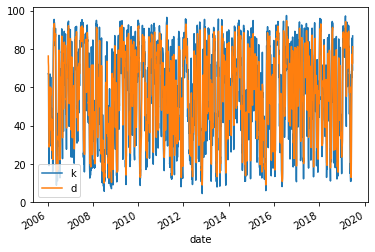

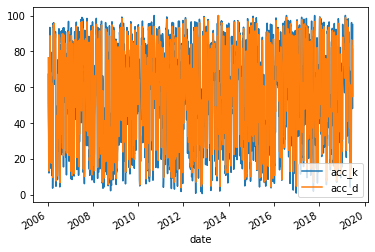

In [164]:
# 標準答案

import talib
from talib import abstract

import numpy as np
import pandas as pd

df_current = df_daily.copy()
K,D = talib.STOCH(high = np.array(df_current['low']), # 最低價
                  low = np.array(df_current['high']),  # 最高價
                  close = np.array(df_current['close']), # 收盤價
                  fastk_period=9,
                  slowk_period=3,
                  slowk_matype=0,
                  slowd_period=3,
                  slowd_matype=0)

df_kd = abstract.STOCH(df_current)

df_current['acc_k'] = df_kd['slowk']
df_current['acc_d'] = df_kd['slowd']
df_current.to_csv('current.csv')
df_current.tail()

%matplotlib inline
df_current.plot(y=['k', 'd'])
df_current.plot(y=['acc_k', 'acc_d'])

In [159]:
# 找出黃金交叉

# 前個k < 前個d & 現在k > 現在d & k值向上
buy = (df_daily.shift()['k'] < df_daily.shift()['d']) & \
        (df_daily['k'] > df_daily['d']) & \
        (df_daily['k'] > df_daily.shift()['k']) & \
        (df_daily['k'] > 80)

# note: 若將k值向上超過80才買入 或 低於20才賣出的條件取消，會輸很慘
# 但加上上述條件後 累積報酬率非常可觀 why?

acc_buy = (df_current.shift(1)['acc_k'] < df_current.shift(1)['acc_d']) & \
            (df_current['acc_k'] > df_current['acc_d']) & \
            (df_current['acc_k'] > df_current.shift()['acc_k']) & \
            (df_current['acc_k'] > 80)

sell =  (df_daily.shift(1)['k'] > df_daily.shift(1)['d']) & \
        (df_daily['k'] < df_daily['d']) & \
        (df_daily['k'] < df_daily.shift()['k']) & \
        (df_daily['k'] < 20)

acc_sell = (df_current.shift(1)['acc_k'] > df_current.shift(1)['acc_d']) & \
            (df_current['acc_k'] < df_current['acc_d']) & \
            (df_current['acc_k'] < df_current.shift()['acc_k']) & \
            (df_current['acc_k'] < 20)

buy[buy == True]
accuracy_buy[accuracy_buy == True]

# 持有股票時機
hold = pd.Series(np.nan, index = df_daily.index)
hold[buy == True] = 1
hold[sell == True] = 0
hold = hold.ffill()
hold = hold.shift()

acc_hold = pd.Series(np.nan, index = df_daily.index)
acc_hold[acc_buy == True] = 1
acc_hold[acc_sell == True] = 0
acc_hold = acc_hold.ffill()
acc_hold = acc_hold.shift()

df_current['buy'] = buy.astype(int)
df_current['acc_buy'] = acc_buy.astype(int)

df_current['sell'] = buy.astype(int)
df_current['acc_sell'] = acc_buy.astype(int)

df_current['hold'] = hold
df_current['acc_hold'] = acc_hold

df_current.to_csv('reference.csv')

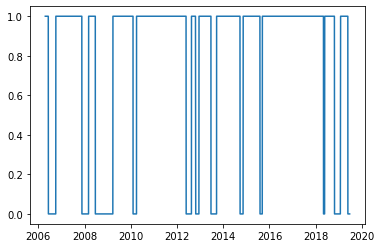

In [160]:
import matplotlib.pyplot as plt

plt.plot(hold)
plt.show()

In [161]:
df_current.to_csv('reference.csv')


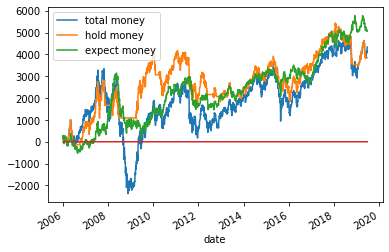

In [162]:
import matplotlib.pyplot as plt

# 大盤累積報酬率
ret = df_daily.shift(-1)['close'] - df_daily['close']
cret_total = ret.cumsum()
ax1 = cret_total.plot(label='total money')
h1, l1 = ax1.get_legend_handles_labels()

# 計算 持有累積報酬率
ret[hold == 0] = 0
cret = ret.cumsum()
ax2 = cret.plot(label='hold money')
h2, l2 = ax2.get_legend_handles_labels()

# # 計算 預期持有累積報酬率
acc_ret = df_daily.shift(-1)['close'] - df_daily['close']
acc_ret[acc_hold == 0] = 0
acc_cret = acc_ret.cumsum()
ax3 = acc_cret.plot(label='expect money')
h3, l3 = ax3.get_legend_handles_labels()

pd.Series(0, index = df_daily.index).plot()

plt.legend(h3, l3, loc=2)

plt.show()


In [163]:
# 找出高檔超買，低檔超賣

# KD>80=高檔超買，KD<20=低檔超賣
